In [1]:
# pip install kagglehub

## Download dataset

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("orvile/airline-market-fare-prediction-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/stefan.horodenski/.cache/kagglehub/datasets/orvile/airline-market-fare-prediction-data/versions/1


## Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint as pp
import seaborn as sns
import math
import statsmodels.api as sm

## Read data

In [4]:
path_file = path + '/Airline_Market_Fare_Prediction_Data/MarketFarePredictionData.csv'
df = pd.read_csv(path_file)
df.head()

,MktCoupons,OriginCityMarketID,DestCityMarketID,OriginAirportID,DestAirportID,Carrier,NonStopMiles,RoundTrip,ODPairID,Pax,...,Circuity,Slot,Non_Stop,MktMilesFlown,OriginCityMarketID_freq,DestCityMarketID_freq,OriginAirportID_freq,DestAirportID_freq,Carrier_freq,ODPairID_freq
0,2,178,152,170,255,6,1807.0,1.0,4035,136.0,...,1.367460,0,0.0,1992.449761,0.004138,0.039783,0.004138,0.022049,0.116826,0.000132
1,2,178,152,170,194,20,1798.0,1.0,4035,136.0,...,1.051724,0,0.0,1992.449761,0.004138,0.039783,0.004138,0.008368,0.307651,0.000132
2,2,178,152,170,260,6,1784.0,0.0,4035,136.0,...,1.034753,0,0.0,1992.449761,0.004138,0.039783,0.004138,0.009366,0.116826,0.000132
3,2,178,152,170,255,6,1807.0,1.0,4035,136.0,...,1.029884,0,0.0,1992.449761,0.004138,0.039783,0.004138,0.022049,0.116826,0.000132
4,2,178,152,170,194,20,1798.0,1.0,4035,136.0,...,1.062291,0,0.0,1992.449761,0.004138,0.039783,0.004138,0.008368,0.307651,0.000132


In [5]:
print(len(df))
print(len(df.drop_duplicates()))
df = df.drop_duplicates()

1581278
63373


In [6]:
df.columns

Index(['MktCoupons', 'OriginCityMarketID', 'DestCityMarketID',
       'OriginAirportID', 'DestAirportID', 'Carrier', 'NonStopMiles',
       'RoundTrip', 'ODPairID', 'Pax', 'CarrierPax', 'Average_Fare',
       'Market_share', 'Market_HHI', 'LCC_Comp', 'Multi_Airport', 'Circuity',
       'Slot', 'Non_Stop', 'MktMilesFlown', 'OriginCityMarketID_freq',
       'DestCityMarketID_freq', 'OriginAirportID_freq', 'DestAirportID_freq',
       'Carrier_freq', 'ODPairID_freq'],
      dtype='object')

In [7]:
print('Variables names:', list(df.columns))

Variables names: ['MktCoupons', 'OriginCityMarketID', 'DestCityMarketID', 'OriginAirportID', 'DestAirportID', 'Carrier', 'NonStopMiles', 'RoundTrip', 'ODPairID', 'Pax', 'CarrierPax', 'Average_Fare', 'Market_share', 'Market_HHI', 'LCC_Comp', 'Multi_Airport', 'Circuity', 'Slot', 'Non_Stop', 'MktMilesFlown', 'OriginCityMarketID_freq', 'DestCityMarketID_freq', 'OriginAirportID_freq', 'DestAirportID_freq', 'Carrier_freq', 'ODPairID_freq']


# Exploring dataset

In [8]:
id_like_cols = [
    'OriginCityMarketID', 'DestCityMarketID',
    'OriginAirportID', 'DestAirportID',
    'ODPairID', 'OriginCityMarketID_freq',
    'DestCityMarketID_freq', 'OriginAirportID_freq',
    'DestAirportID_freq', 'Carrier_freq', 'ODPairID_freq'
]

numeric_cols = df.select_dtypes(include=[np.number]).columns
# print(numeric_cols)
numeric_cols = [col for col in numeric_cols if col not in id_like_cols]

pseudo_categorical_cols = [col for col in numeric_cols if df[col].nunique() <= 10]

true_numeric_cols = [col for col in numeric_cols if col not in pseudo_categorical_cols]

print(f"Number of rows: {df.shape[0]}, number of columns: {df.shape[1]}")

print("\nTrue numeric columns (excluding IDs and categories):")
print(true_numeric_cols)

print("\nDescriptive statistics for true numeric variables:")
display(df[true_numeric_cols].describe())

print("\nPseudo-categorical variables (numeric type, few unique values):")
for col in pseudo_categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values -> {sorted(df[col].unique())}")

print("\nMissing values (percentage):")
missing_percent = df.isnull().mean() * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))



Number of rows: 63373, number of columns: 26

True numeric columns (excluding IDs and categories):
['Carrier', 'NonStopMiles', 'Pax', 'CarrierPax', 'Average_Fare', 'Market_share', 'Market_HHI', 'Circuity', 'MktMilesFlown']

Descriptive statistics for true numeric variables:


,Carrier,NonStopMiles,Pax,CarrierPax,Average_Fare,Market_share,Market_HHI,Circuity,MktMilesFlown
count,63373.000000,63373.000000,6.337300e+04,63373.000000,63373.000000,63373.000000,63373.000000,63373.000000,63373.000000
mean,14.544790,1321.352611,1.354854e+05,44723.379846,225.206069,0.512172,5612.054415,1.177076,1375.594434
std,7.287703,701.577909,2.011212e+05,71165.116303,74.326578,0.331735,2759.880684,0.282412,714.849555
min,0.000000,100.000000,1.000000e+00,1.000000,67.390000,0.050011,1553.420000,1.000000,102.000000
25%,6.000000,794.000000,1.089500e+04,4239.000000,177.870000,0.217519,3342.450000,1.000000,848.432343
50%,20.000000,1182.000000,5.527800e+04,17790.000000,219.380000,0.427581,4841.230000,1.041625,1242.040698
75%,20.000000,1790.000000,1.780350e+05,54005.000000,262.020000,0.871842,8150.530000,1.242616,1870.640777
max,24.000000,5095.000000,1.495396e+06,706835.000000,1265.990000,1.000000,10000.000000,2.985825,5096.520737



Pseudo-categorical variables (numeric type, few unique values):
MktCoupons: 3 unique values -> [1, 2, 3]
RoundTrip: 2 unique values -> [0.0, 1.0]
LCC_Comp: 2 unique values -> [0, 1]
Multi_Airport: 2 unique values -> [0, 1]
Slot: 2 unique values -> [0, 1]
Non_Stop: 2 unique values -> [0.0, 1.0]

Missing values (percentage):
Series([], dtype: float64)


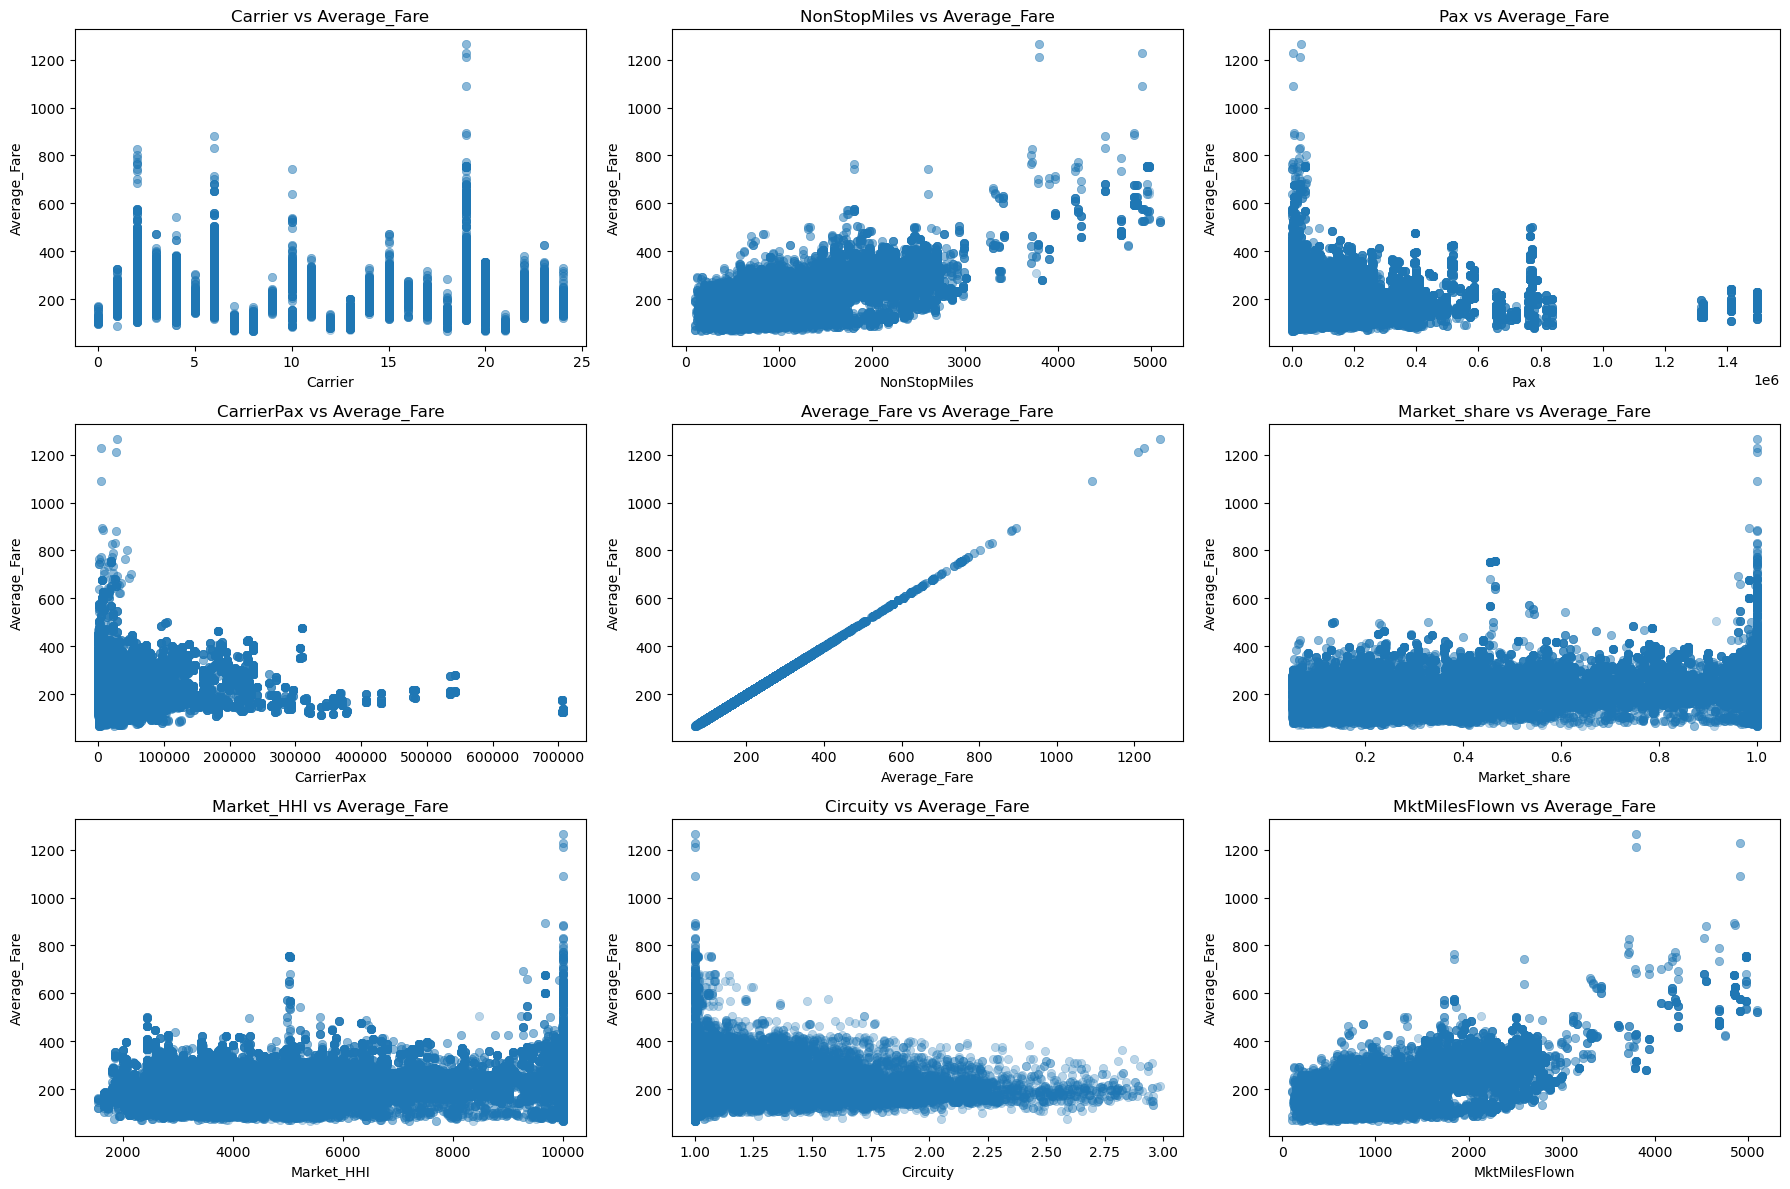

In [9]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(true_numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=df, x=true_numeric_cols[i], y='Average_Fare', alpha=0.3, edgecolor=None)
    plt.title(f"{col} vs Average_Fare")
    plt.xlabel(col)
    plt.ylabel("Average_Fare")

plt.tight_layout()
plt.show()

Correlation matrix:
                 Carrier  NonStopMiles       Pax  CarrierPax  Average_Fare  \
Carrier        1.000000     -0.120348 -0.151757   -0.198196     -0.110109   
NonStopMiles  -0.120348      1.000000 -0.000686   -0.019558      0.685185   
Pax           -0.151757     -0.000686  1.000000    0.786820     -0.086988   
CarrierPax    -0.198196     -0.019558  0.786820    1.000000      0.025762   
Average_Fare  -0.110109      0.685185 -0.086988    0.025762      1.000000   
Market_share   0.026919      0.072404 -0.369743   -0.068891      0.227588   
Market_HHI     0.081591      0.079331 -0.467374   -0.288320      0.185157   
Circuity       0.089020     -0.140317  0.072896    0.124635     -0.016053   
MktMilesFlown -0.099618      0.995413 -0.024975   -0.040963      0.688362   

               Market_share  Market_HHI  Circuity  MktMilesFlown  
Carrier            0.026919    0.081591  0.089020      -0.099618  
NonStopMiles       0.072404    0.079331 -0.140317       0.995413  
Pax    

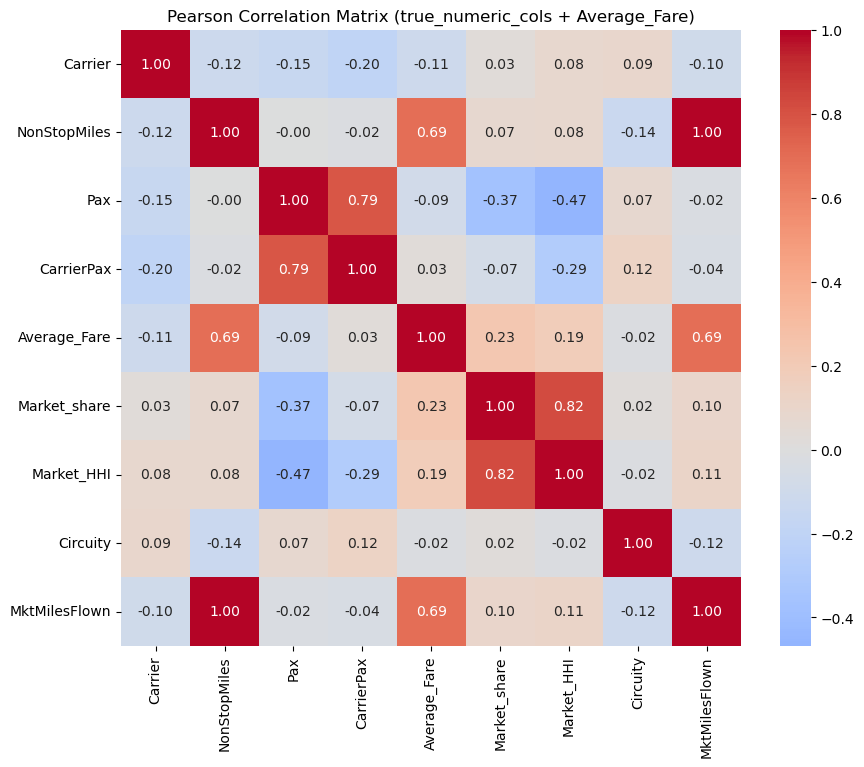


Correlations with Average_Fare:
Average_Fare     1.000000
MktMilesFlown    0.688362
NonStopMiles     0.685185
Market_share     0.227588
Market_HHI       0.185157
CarrierPax       0.025762
Circuity        -0.016053
Pax             -0.086988
Carrier         -0.110109
Name: Average_Fare, dtype: float64


In [10]:
corr_matrix = df[true_numeric_cols].corr()

print("Correlation matrix:\n", corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Pearson Correlation Matrix (true_numeric_cols + Average_Fare)")
plt.show()

print("\nCorrelations with Average_Fare:")
print(corr_matrix['Average_Fare'].sort_values(ascending=False))

Pearson correlation matrix for pseudo-categorical variables with Average_Fare:
                MktCoupons  RoundTrip  LCC_Comp  Multi_Airport      Slot  \
MktCoupons       1.000000   0.077117  0.307052       0.097776  0.010496   
RoundTrip        0.077117   1.000000  0.014615       0.000786 -0.007589   
LCC_Comp         0.307052   0.014615  1.000000       0.172191  0.042735   
Multi_Airport    0.097776   0.000786  0.172191       1.000000  0.220149   
Slot             0.010496  -0.007589  0.042735       0.220149  1.000000   
Non_Stop        -0.953084  -0.055968 -0.328596      -0.088841 -0.004580   
Average_Fare     0.381027   0.025143 -0.070558       0.070397  0.032888   

               Non_Stop  Average_Fare  
MktCoupons    -0.953084      0.381027  
RoundTrip     -0.055968      0.025143  
LCC_Comp      -0.328596     -0.070558  
Multi_Airport -0.088841      0.070397  
Slot          -0.004580      0.032888  
Non_Stop       1.000000     -0.339327  
Average_Fare  -0.339327      1.000000  

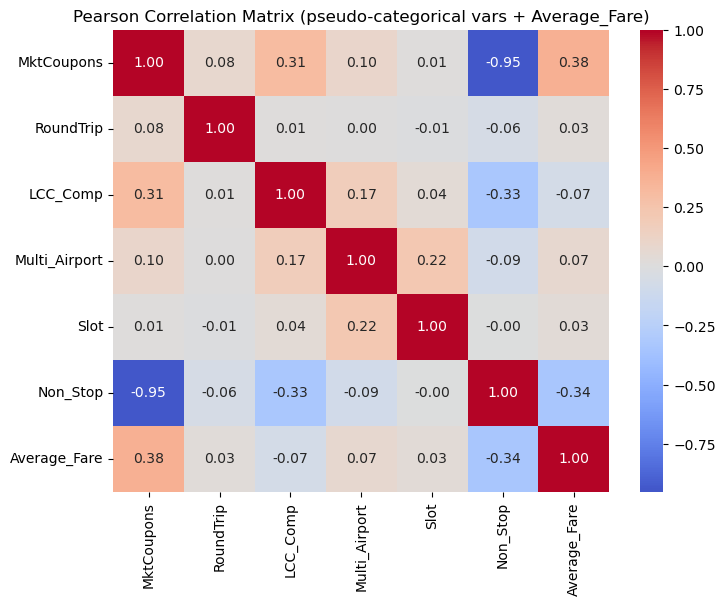

In [11]:
cols_for_corr = pseudo_categorical_cols + ['Average_Fare']

corr_matrix_pseudo = df[cols_for_corr].corr()

print("Pearson correlation matrix for pseudo-categorical variables with Average_Fare:\n", corr_matrix_pseudo)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_pseudo, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Pearson Correlation Matrix (pseudo-categorical vars + Average_Fare)")
plt.show()

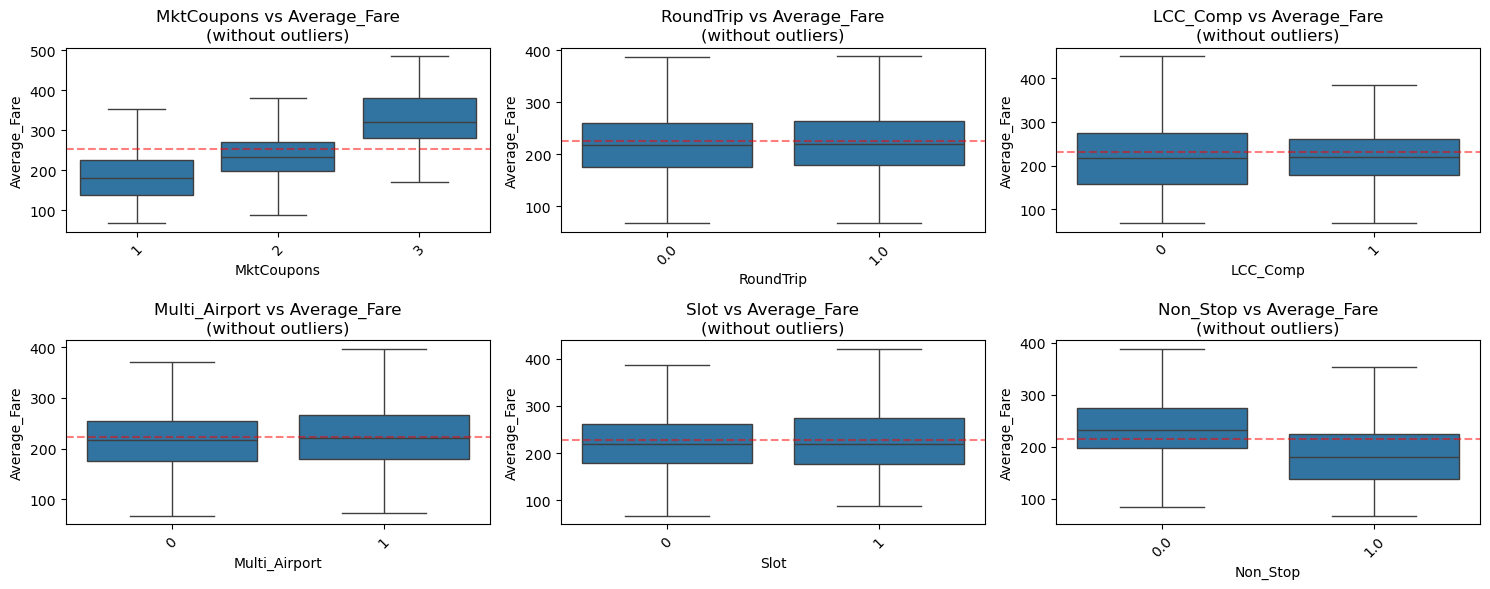

In [12]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(pseudo_categorical_cols):
    plt.subplot(2, math.ceil(len(pseudo_categorical_cols)/2), i+1)

    sns.boxplot(data=df, x=col, y='Average_Fare', showfliers=False)

    means = df.groupby(col)['Average_Fare'].mean()
    plt.axhline(y=means.mean(), color='red', linestyle='--', alpha=0.5)

    plt.title(f'{col} vs Average_Fare\n(without outliers)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

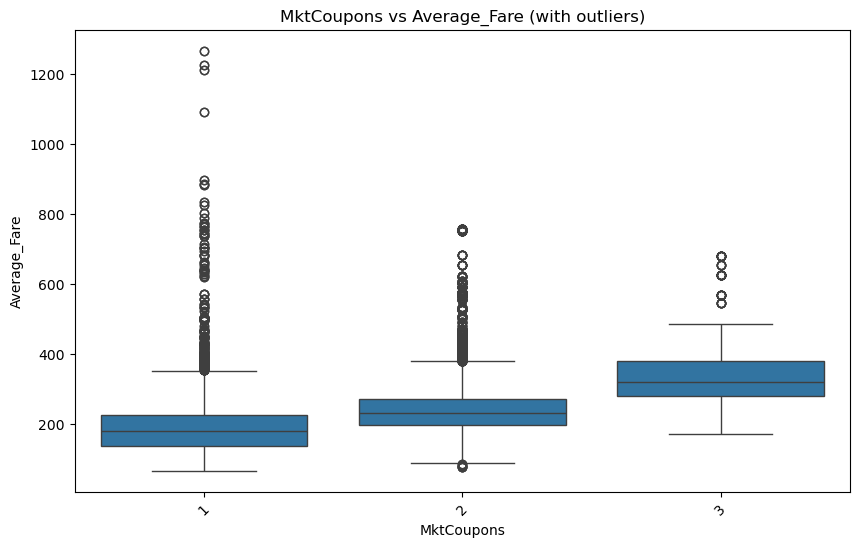

            count    mean  median     min      max
MktCoupons                                        
1           19675  187.62  179.93   67.39  1265.99
2           42180  238.90  232.01   76.78   756.50
3            1518  331.94  319.74  170.64   678.73


In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='MktCoupons', y='Average_Fare')
plt.title('MktCoupons vs Average_Fare (with outliers)')
plt.xticks(rotation=45)
plt.show()

stats = df.groupby('MktCoupons')['Average_Fare'].agg(['count', 'mean', 'median', 'min', 'max']).round(2)
print(stats)

# ID like variables

ID variables correlations with Average_Fare:
Average_Fare               1.000000
ODPairID_freq              0.091329
DestAirportID_freq         0.090639
OriginAirportID_freq       0.089665
OriginCityMarketID_freq    0.088899
DestCityMarketID_freq      0.088132
DestAirportID              0.041559
DestCityMarketID           0.029794
OriginAirportID            0.024794
ODPairID                   0.013428
OriginCityMarketID         0.013113
Carrier_freq               0.001640
Name: Average_Fare, dtype: float64


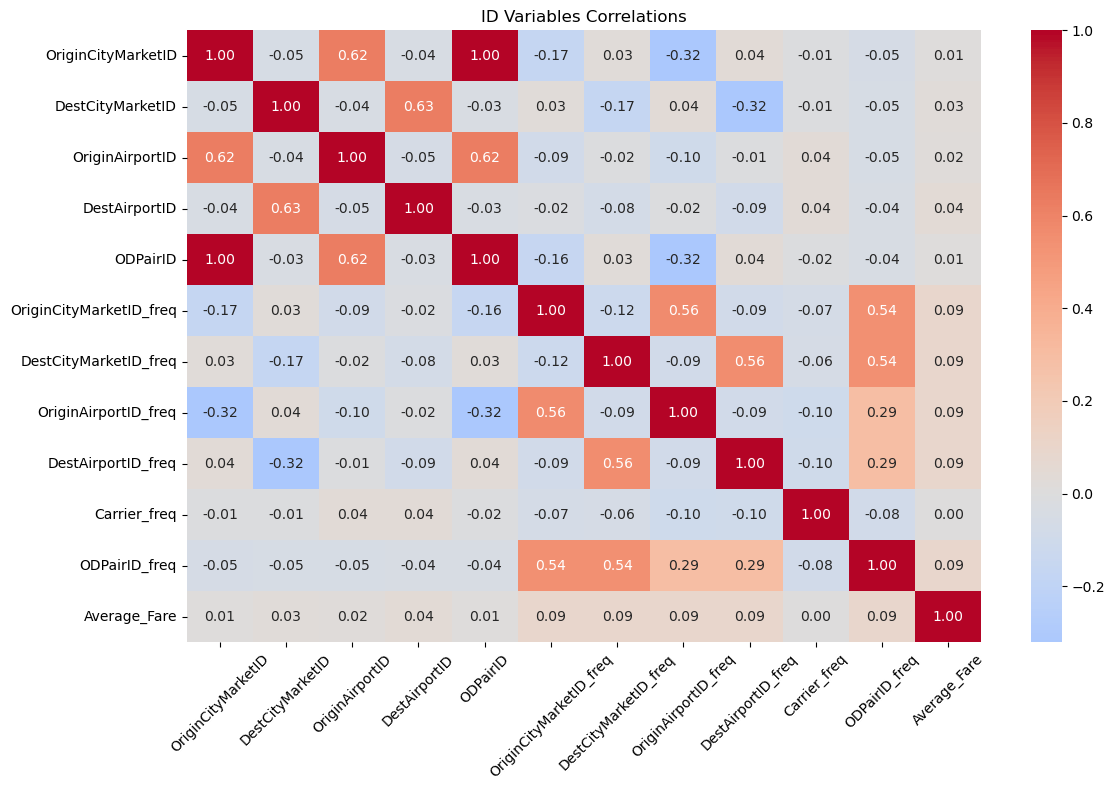

/var/folders/_4/qm9nb14n0vd7nkvr8z_5b7w40000gn/T/ipykernel_22017/1064989949.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation=45)
/var/folders/_4/qm9nb14n0vd7nkvr8z_5b7w40000gn/T/ipykernel_22017/1064989949.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation=45)
/var/folders/_4/qm9nb14n0vd7nkvr8z_5b7w40000gn/T/ipykernel_22017/1064989949.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation=45)
/var/folders/_4/qm9nb14n0vd7nkvr8z_5b7w40000gn/T/ipykernel_22017/1064989949.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of t

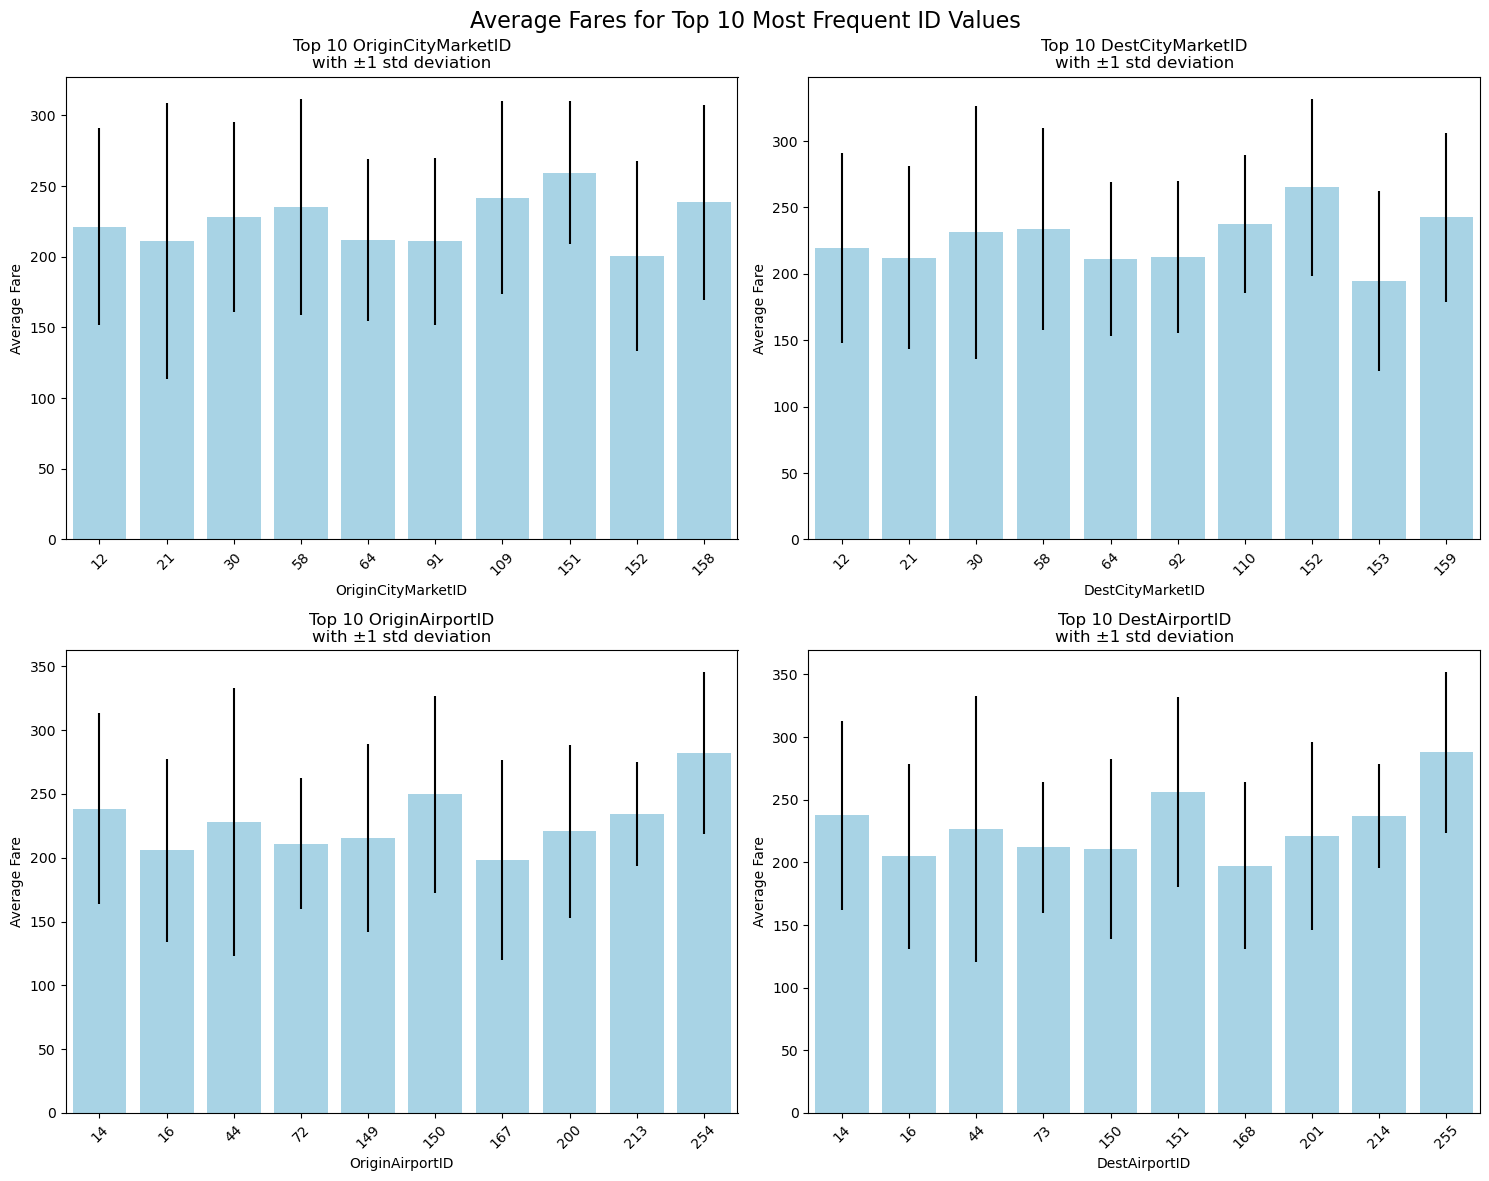

In [14]:
id_cols_with_fare = id_like_cols + ['Average_Fare']
corr_matrix_id = df[id_cols_with_fare].corr()

print("ID variables correlations with Average_Fare:")
print(corr_matrix_id['Average_Fare'].sort_values(ascending=False))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_id, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("ID Variables Correlations")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Average Fares for Top 10 Most Frequent ID Values', fontsize=16)

for idx, col in enumerate(['OriginCityMarketID', 'DestCityMarketID', 'OriginAirportID', 'DestAirportID']):
    i, j = idx // 2, idx % 2
    top_10 = df[col].value_counts().nlargest(10).index

    # Calculate means and standard deviations
    stats = df[df[col].isin(top_10)].groupby(col)['Average_Fare'].agg(['mean', 'std']).sort_values('mean', ascending=False)

    # Plot bars with error bars
    sns.barplot(x=stats.index, y=stats['mean'], yerr=stats['std'],
                ax=axes[i,j], capsize=5, color='skyblue', alpha=0.8)

    axes[i,j].set_title(f'Top 10 {col}\nwith ±1 std deviation')
    axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation=45)
    axes[i,j].set_ylabel('Average Fare')

plt.tight_layout()
plt.show()

## Simple regression
**true_numeric_cols** and **pseudo_categorical_cols**

In [15]:
regresion_cols = true_numeric_cols + pseudo_categorical_cols
X_reg = df[regresion_cols].drop(columns=['Average_Fare'])
y_reg = df['Average_Fare']
X_reg = sm.add_constant(X_reg)

model = sm.OLS(y_reg, X_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Average_Fare   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     5726.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:11:56   Log-Likelihood:            -3.3705e+05
No. Observations:               63373   AIC:                         6.741e+05
Df Residuals:                   63358   BIC:                         6.743e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            69.5594      3.185     21.842

## Remove correlated variables

In [16]:
to_remove_numeric = ['MktMilesFlown', 'Market_HHI', 'Pax']
to_remove_categorical = ['MktCoupons']
true_numeric_cols_nocorr = [x for x in true_numeric_cols if not x in to_remove_numeric]
pseudo_categorical_cols_nocorr = [x for x in pseudo_categorical_cols if not x in to_remove_categorical]

regresion_cols_nocorr = true_numeric_cols_nocorr + pseudo_categorical_cols_nocorr
X_reg_nocorr = df[regresion_cols_nocorr].drop(columns=['Average_Fare'])
y_reg_nocorr = df['Average_Fare']
X_reg_nocorr = sm.add_constant(X_reg_nocorr)

model_nocorr = sm.OLS(y_reg_nocorr, X_reg_nocorr).fit()
print(model_nocorr.summary())

                            OLS Regression Results                            
Dep. Variable:           Average_Fare   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     7321.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:11:56   Log-Likelihood:            -3.3863e+05
No. Observations:               63373   AIC:                         6.773e+05
Df Residuals:                   63362   BIC:                         6.774e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           144.4680      1.721     83.923

## Prepare data for NN

In [17]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.model_selection import train_test_split

In [24]:
to_remove_numeric = ['MktMilesFlown', 'Market_HHI', 'Pax']
to_remove_categorical = ['MktCoupons']
true_numeric_cols_nocorr = [x for x in true_numeric_cols if not x in to_remove_numeric]
pseudo_categorical_cols_nocorr = [x for x in pseudo_categorical_cols if not x in to_remove_categorical]

regresion_cols_nocorr = true_numeric_cols_nocorr + pseudo_categorical_cols_nocorr
regresion_cols_nocorr.remove('Average_Fare')  # modify list in-place
X_names = regresion_cols_nocorr

X_data = df[X_names]
y_data = df['Average_Fare']

X_tensor = torch.tensor(X_data.values, dtype=torch.float32)
y_tensor = torch.tensor(y_data.values, dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

X_mean, X_std = X_tensor.mean(dim=0), X_tensor.std(dim=0)
y_mean, y_std = y_tensor.mean(), y_tensor.std()

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std
y_train = (y_train - y_mean) / y_std
y_test  = (y_test  - y_mean) / y_std

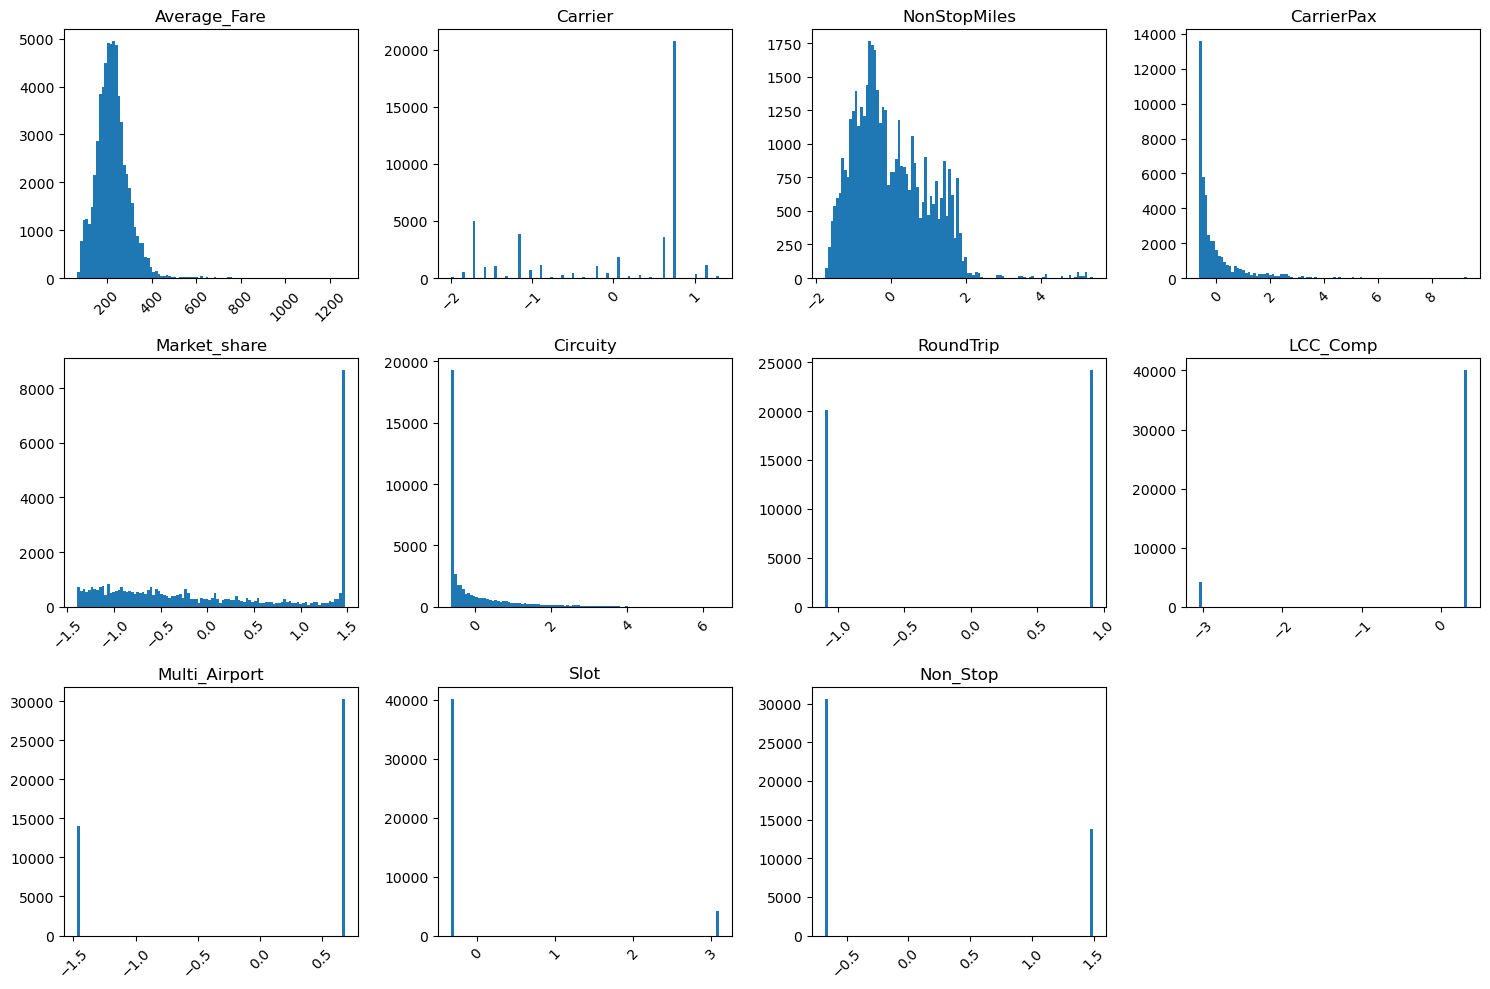

In [25]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 4, 1)
plt.hist(y_tensor, 100)
plt.title('Average_Fare')
plt.xticks(rotation=45)

for i, col in enumerate(X_names):

    plt.subplot(3, 4, i+2)

    plt.hist(X_train.squeeze()[:, i], bins=100)
    # plt.axhline(y=means.mean(), color='red', linestyle='--', alpha=0.5)

    plt.title(f'{col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Simple NN

In [26]:
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

In [83]:
class FarePredictDeepNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], output_size=1, dropout=0.2):
        super(FarePredictDeepNN, self).__init__()

        layers = []
        in_size = input_size

        for idx, h in enumerate(hidden_sizes):
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.BatchNorm1d(h))

            layers.append(nn.ReLU())

            layers.append(nn.Dropout(dropout))
            in_size = h

        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [84]:
input_size = len(X_names)

model = FarePredictDeepNN(input_size, hidden_sizes=[128, 64, 32], output_size=1, dropout=0.2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [85]:
# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset   = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [91]:
# Training loop
train_loss_arr = []
val_loss_arr   = []
epoch_arr      = []

for epoch in range(1000):

    epoch_arr.append(epoch)
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            v_loss = criterion(val_outputs, val_y)
            val_loss += v_loss.item()

    val_loss /= len(val_loader.dataset)

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

Epoch 0, Train Loss: 0.003986, Val Loss: 0.003046
Epoch 10, Train Loss: 0.004018, Val Loss: 0.003327
Epoch 20, Train Loss: 0.003970, Val Loss: 0.003227
Epoch 30, Train Loss: 0.003993, Val Loss: 0.003294
Epoch 40, Train Loss: 0.003994, Val Loss: 0.003059
Epoch 50, Train Loss: 0.003991, Val Loss: 0.003322
Epoch 60, Train Loss: 0.004039, Val Loss: 0.003570
Epoch 70, Train Loss: 0.003903, Val Loss: 0.003314
Epoch 80, Train Loss: 0.004017, Val Loss: 0.003542
Epoch 90, Train Loss: 0.003925, Val Loss: 0.002999
Epoch 100, Train Loss: 0.003972, Val Loss: 0.003124
Epoch 110, Train Loss: 0.003920, Val Loss: 0.003116
Epoch 120, Train Loss: 0.003941, Val Loss: 0.003279
Epoch 130, Train Loss: 0.003943, Val Loss: 0.003091
Epoch 140, Train Loss: 0.003994, Val Loss: 0.003038
Epoch 150, Train Loss: 0.003965, Val Loss: 0.003007
Epoch 160, Train Loss: 0.003943, Val Loss: 0.003241
Epoch 170, Train Loss: 0.004042, Val Loss: 0.003159
Epoch 180, Train Loss: 0.003882, Val Loss: 0.003337
Epoch 190, Train Loss: 

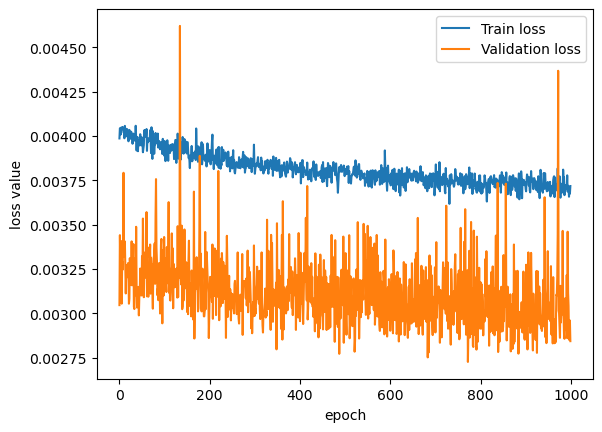

In [93]:
plt.plot(epoch_arr, train_loss_arr, label='Train loss')
plt.plot(epoch_arr, val_loss_arr, label='Validation loss')
plt.xlabel("epoch")
plt.ylabel('loss value')
plt.legend()
plt.savefig('ununstable_tanh_400epochs_lr_1e-4.pdf')

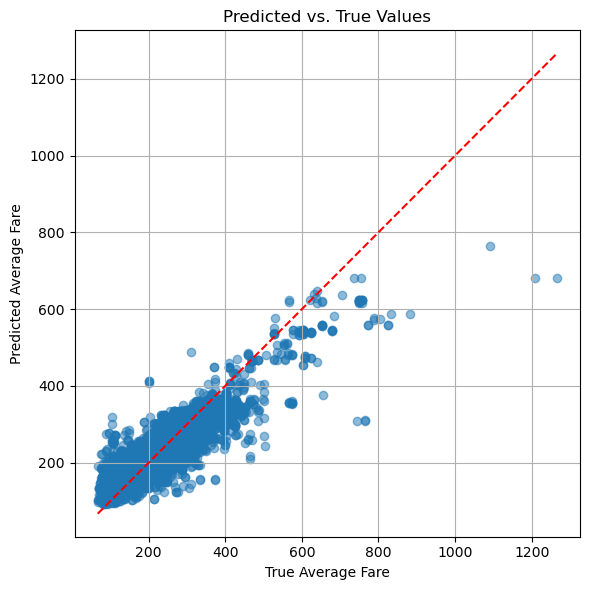

In [89]:
model.eval()

# Predict on the entire test set
with torch.no_grad():
    y_pred = model(X_test).squeeze()

# Denormalize predictions and ground truth
y_pred_denorm = y_pred * y_std + y_mean
y_test_denorm = y_test.squeeze() * y_std + y_mean

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_denorm.numpy(), y_pred_denorm.numpy(), alpha=0.5)
plt.xlabel('True Average Fare')
plt.ylabel('Predicted Average Fare')
plt.title('Predicted vs. True Values')
plt.plot([y_test_denorm.min(), y_test_denorm.max()],
         [y_test_denorm.min(), y_test_denorm.max()],
         'r--')  # Diagonal line
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
rmse = np.sqrt(mse)
print(rmse)

33.139503611255144


In [79]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_denorm, y_pred_denorm)
print(r2)

0.8118007330734837


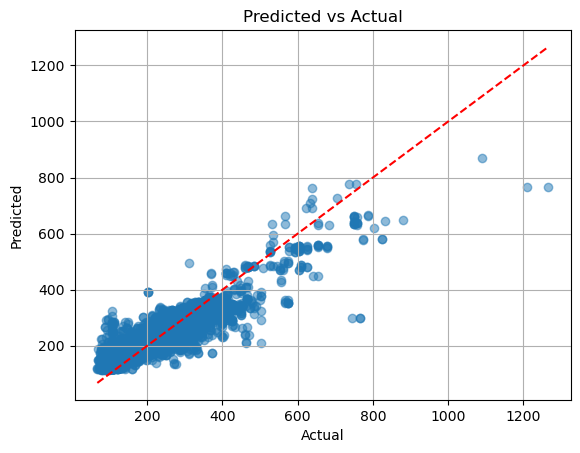

In [38]:
import matplotlib.pyplot as plt
plt.scatter(y_test_denorm, y_pred_denorm, alpha=0.5)
plt.plot([y_test_denorm.min(), y_test_denorm.max()],
         [y_test_denorm.min(), y_test_denorm.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

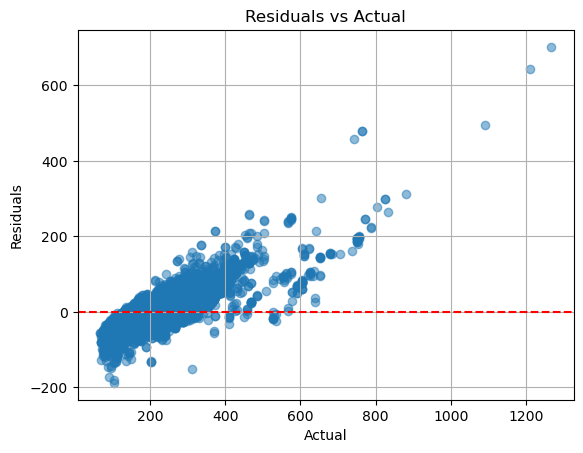

In [48]:
residuals = y_test_denorm - y_pred_denorm
plt.scatter(y_test_denorm, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual")
plt.grid(True)
plt.show()
